In [1]:
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
# from Drone_Data_Functions import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as dates

import numpy as np
import h5py, glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from datetime import datetime

import os
import math

In [2]:
# Drone housekeeping testing notebook
# Updated June 2022

# config vars
raw_csv_dir = "/hirax/all_drone_data/datcon_csv"

#output_log = "/hirax/all_drone_data/csv_catalog.txt"
output_log = "/hirax/all_drone_data/csv_catalog.csv"

col_dict = {
    "Lat":"RTKdata:Lat_P",
    "Lon":"RTKdata:Lon_P",
    "hmsl":"RTKdata:Hmsl_P",
    "sec_elapsed":"offsetTime",
    "datetimestamp":"GPS:dateTimeStamp",
    "tick":"Tick#",
    "vel":"IMU_ATTI(0):velComposite",
    "yaw_rtk":"RTKdata:YAW",
    "pitch_rtk":"RTKdata:pitch",
    "pitch":"IMU_ATTI(0):pitch",
    "roll":"IMU_ATTI(0):roll",
    "yaw":"IMU_ATTI(0):yaw",
    "yaw_360":"IMU_ATTI(0):yaw360",
    "IMU_lat":"IMUEX(0):rtk_Latitude",
    "IMU_lon":"IMUEX(0):rtk_Longitude",
    "IMU_hmsl":"IMUEX(0):rtk_Alti",
}

boxes = [
    ["LFOP",       [41.319500, 41.322000], [-72.923480, -72.920865]],
    ["WL Roof",    [41.318800, 41.319467], [-72.921791, -72.920784]],
    ["WL Parking", [41.318028, 41.318800], [-72.921306, -72.919640]],
    ["BMX",        [40.867943, 40.871194], [-72.869294, -72.862603]],
    ["OVRO",       [37.223541, 37.242025], [-118.303752, -118.272200]],
]

for key, val in col_dict.items():
    print(key+", "+val)
    
    
print(boxes[0][1][0])

Lat, RTKdata:Lat_P
Lon, RTKdata:Lon_P
hmsl, RTKdata:Hmsl_P
sec_elapsed, offsetTime
datetimestamp, GPS:dateTimeStamp
tick, Tick#
vel, IMU_ATTI(0):velComposite
yaw_rtk, RTKdata:YAW
pitch_rtk, RTKdata:pitch
pitch, IMU_ATTI(0):pitch
roll, IMU_ATTI(0):roll
yaw, IMU_ATTI(0):yaw
yaw_360, IMU_ATTI(0):yaw360
IMU_lat, IMUEX(0):rtk_Latitude
IMU_lon, IMUEX(0):rtk_Longitude
IMU_hmsl, IMUEX(0):rtk_Alti
41.3195


In [3]:
# Function for adding sub-second accuracy to DJI timestamps

# last edited June 7th, 2022
# cut off last 10 rows due to ongoing GPS glitches
# added the ability to skip initial NaT rows

def interp_time(df_in):

    # find where the GPS turns on
    gps_idx = df_in[df_in.gpsUsed == True].index[0]
    
    # detect places where the GPS:dateTimeStamp column jumps backwards by a large amount, and skip them
    ts_dt = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx:-10])
    if np.argmin(ts_dt) > gps_idx: 
        gps_idx += np.argmin(ts_dt)
        print("Skipped a section where time ran backwards")

    # interpolate the time and see if it works out!
    while (gps_idx < len(df_in)):
        
        # find the first datetimestamp that's a real timestamp (rather than NaT)
        first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
        while(type(first_dts) == type(0.1)): 
            gps_idx += 1
            first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
        
        # look for where the datetimestamp ticks
        start_sec = int(first_dts[-3:-1])
        while(int(df_in["GPS:dateTimeStamp"][gps_idx][-3:-1]) == start_sec):
            gps_idx = gps_idx + 1

        # use this reference timestamp to convert the offsetTime column into proper datetimes
        start_dt = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx])
        offsets = np.array(df_in["offsetTime"]-df_in["offsetTime"][gps_idx])
        offsets = pd.to_timedelta(offsets, unit='s')
        timestamps = start_dt + offsets

        # put them in the dataframe
        df_in = df_in.assign(timestamp = timestamps)
        df_in = df_in.assign(UTC = timestamps)

        # check for excessive error by comparing the interpolated and uninterpolated timestamp columns
        gps_dts = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx:-20]).values
        interp_dts = pd.to_datetime(df_in["timestamp"][gps_idx:-20]).values
        
        if (np.mean(np.abs(gps_dts - interp_dts)/np.timedelta64(1,'ms')) < 1000):
            print("Timestamp interpolation succeeded")
            break
        else:
            print("Detected >1s error, retrying")
            gps_idx += 11 # increment the start timestamp index by an arbitrary amount and retry
    
    return df_in

In [4]:
# make a new dataframe with only the columns that Will wants
def extract_cols(df):
    smol_df = pd.DataFrame(columns=["Lat", "Lon", "hmsl"])
    for key, val in col_dict.items():
        smol_df[key] = df[val]
    
    smol_df = smol_df.where(smol_df != 0.)
    smol_df.dropna(inplace=True)
    
    if "timestamp" in df.columns:
        smol_df["UTC"] = df["timestamp"]
    else:
        print("Could not extract a timestamp column")
    if len(smol_df.columns) == 0:
        print("File "+name+" is empty. YEET")
        return(pd.DataFrame(columns=[]))
    return(smol_df)

In [16]:
df = pd.read_csv(raw_csv_dir+"/FLY397.csv")
#df = pd.read_csv(raw_csv_dir+"/FLY442.csv")

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (106,107,142,143,144,145,146,147,148,149,150,151,364,366,368,369,1291,1382) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [26]:
keys = df.keys()
for key in keys:
    if 'GPS(0)' in key or 'lat' in key or "LAT" in key: print(key)

General:relativeHeight
GPS(0):Long
GPS(0):Lat
GPS(0):Date
GPS(0):Time
GPS(0):heightMSL
GPS(0):hDOP
GPS(0):pDOP
GPS(0):sAcc
GPS(0):numGPS
GPS(0):numGLNAS
GPS(0):numSV
GPS(0):velN
GPS(0):velE
GPS(0):velD
rc_gps_data:latitude
gs_rtk_data:hrz_lati
ahrs_data:ns_lati


In [33]:
to_process = ["FLY397.csv"]

#for fname in to_process:

fname = to_process[0]
df = pd.read_csv(raw_csv_dir+"/"+fname)


drone go zoom
35:29
Skipped a section where time ran backwards
Timestamp interpolation succeeded
41.3254337, -72.93391360000001
21166
17004
Max height above takeoff point: 207.817 meters
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
21166
2784
20635


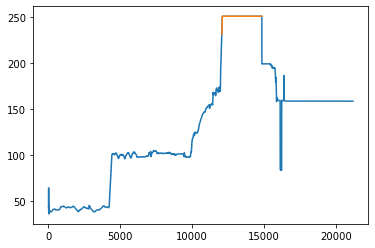

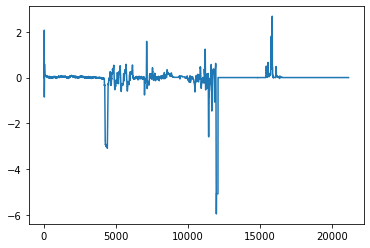

NameError: name 'out_csv_dir' is not defined

In [72]:
# for each file....

# data for the giant google sheet
file_num = fname[3:6]
gps_used = True
file_date = "No datetime found"
motor_status = " "
if (max(df["flightTime"].dropna()) == 0):
    print("No takeoff detected")
else:
    print("drone go zoom")
    motor_status = "FLYING"

processing_failed = False
location = "unknown"

file_length = df.offsetTime.iloc[-1] - df.offsetTime[0]
minutes, seconds = divmod(file_length, 60)
file_length = "{:02d}:{:02d}".format(int(minutes), int(seconds))

print(file_length)

# check if the GPS was used at all
if (len(df[df.gpsUsed == True]) < 10):
    # if not, write that down for the log file
    gps_used = False
    print("No GPS data found")

else:
    # if it was used, run interp_time
    gps_used = True
    df = interp_time(df)
    file_date = str(df.timestamp[0])[:10]


    # find the center of the file, to tag the location
    lats = np.array(df["GPS(0):Lat"])
    lons = np.array(df["GPS(0):Long"])
    alts = np.array(df["GPS(0):heightMSL"])
    mask = np.isnan(lats) | np.equal(lats, 0)
    center_lat = np.median(lats[~mask])
    center_lon = np.median(lons[~mask])
    print(str(center_lat)+", "+str(center_lon))
    for i in range(len(boxes)):
        if (center_lat > boxes[i][1][0] and center_lat < boxes[i][1][1]
           and center_lon > boxes[i][2][0] and center_lon < boxes[i][1][1]):
            location = boxes[i][0]
            print(location)

    # try to figure out if we flew a grid
    grid_alt = 0
    grid_size = 0
    grid_speed = 0
    grid_direction = 0
    grid_heading = 0
    if (motor_status == "FLYING"):
        # mask off the part of the file where the drone was actually flying
        flying_mask = ~df.flightTime.isna() & (df.flightTime > 0)
        flight_df = df[flying_mask]
        print(len(df))
        print(len(flight_df))
        
        f_alts = alts[flying_mask]
    

        # find the max altitude reached relative to the takeoff altitude
        start_alt = f_alts[0]
        max_alt = max(f_alts)
        delta_alt = max_alt - start_alt
        print("Max height above takeoff point: "+str(delta_alt)+" meters")
        
        # figure out how long we spent at that maximum altitude
        height_tolerance = 20 # meters
        grid_mask = alts > (max_alt - height_tolerance) 
        vertvel_mask = np.array((df["GPS(0):velD"] > -1) & (df["GPS(0):velD"] < 1))
        print(type(grid_mask))
        print(type(vertvel_mask))
        print(len(grid_mask))
        print(len(df[grid_mask]))
        print(len(df[vertvel_mask]))
        
        mask_df = df[grid_mask]
        
        fig = plt.figure()
        plt.plot(alts)
        plt.plot(mask_df["GPS(0):heightMSL"])
        plt.show()
        
        fig = plt.figure()
        plt.plot(df["GPS(0):velD"])
        plt.show()

        # cut out a chunk of the lats and lons that we think is the grid

        # convert it into cartesian coords referenced to the center of the grid

        # plot it for good measure

        # measure the size of the grid

        # figure out which direction the grid was facing



    # cleanup manually to avoid memory leaks        
    del lats
    del lons
    del alts

# output the CSV to the processed CSV folder (and also the NPZ to the NPZ folder)
if (processing_failed):
    fil = open(proc_fail_log , 'a')
    fil.write(fname+"\n")
    fil.close()
else: 
    cut_df.to_csv(out_csv_dir+"/"+fname[:-4]+"_processed.csv")
    if gps_used: # only make an NPZ if there's a proper timestamp column
        np.savez(out_npz_dir+"/"+fname[:-4]+"_Drone_Coordinates.npz",timestamp=cut_df['UTC'].values,
                 Lat=cut_df['Lat'].values,Lon=cut_df['Lon'].values,hmsl=cut_df['hmsl'].values, 
                 yaw=cut_df['yaw'].values, vel=cut_df['vel'].values)
    del cut_df

# build the CSV/google sheet line
ml = ml.append({"Flight #":file_num, "Flight status":str(motor_status), "Date":file_date, "Length":file_length, "Location":" "},ignore_index=True)

del df

print(ml)
ml_sort = ml.sort_values("Flight #")
ml_sort.to_csv(master_list, index=False)

print("Finished processing all files")


Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw_rtk', 'pitch_rtk', 'pitch', 'roll', 'yaw',
       'yaw_360', 'IMU_lat', 'IMU_lon', 'IMU_hmsl', 'UTC'],
      dtype='object')


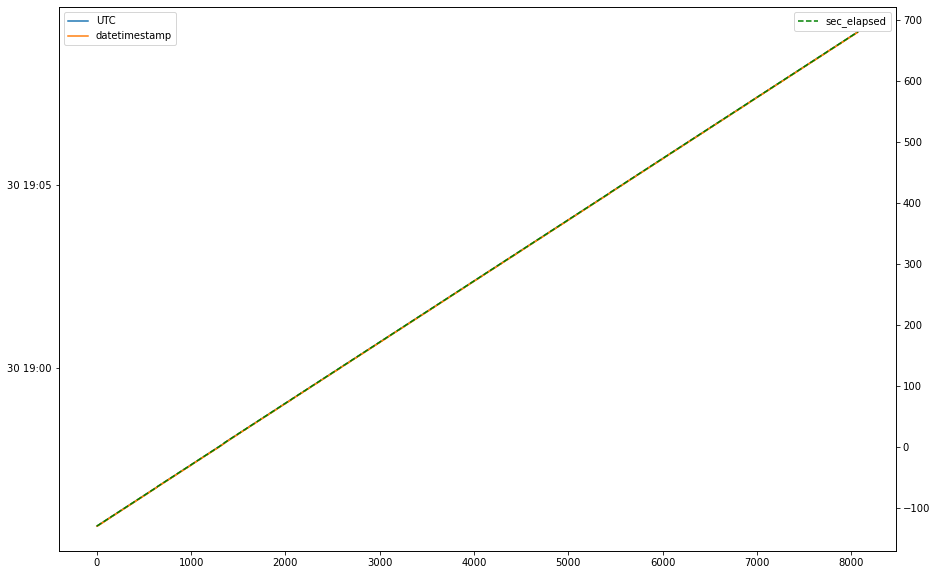

In [55]:
#df = pd.read_csv(out_csv_dir+"/FLY460_processed.csv")
df = pd.read_csv(out_csv_dir+"/FLY458_processed.csv")
df = df.assign(UTC = pd.to_datetime(df.UTC))
df = df.assign(datetimestamp = pd.to_datetime(df.datetimestamp))

print(df.columns)

fig = plt.figure(figsize=(15,10))
plt.plot(df.UTC, label="UTC")
plt.plot(df.datetimestamp, label="datetimestamp")

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df.sec_elapsed, 'g--', label="sec_elapsed")

ax.legend()
ax2.legend()

plt.show()

[0.1   0.1   0.1   ... 0.101 0.1   0.1  ]


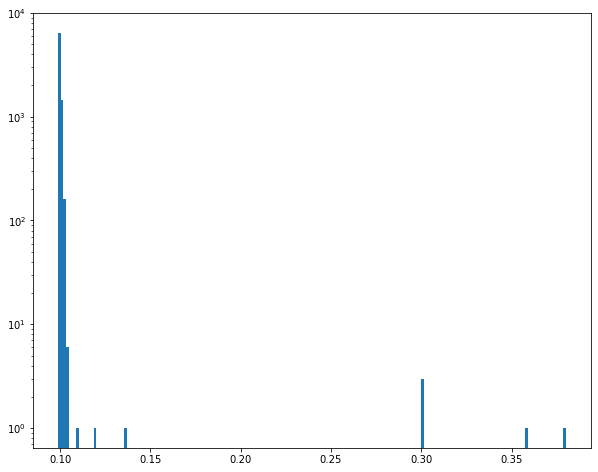

In [64]:
print(np.diff(df.sec_elapsed))
fig = plt.figure(figsize=(10, 8))
plt.hist(np.diff(df.sec_elapsed)[:-1], bins=200)
#plt.hist(np.diff(df.index)[:-1], bins=200)
plt.yscale("log")
plt.show()